**Current Graphs:**



---


Univariate (single variable)

---



Subscription status (Yes/No)

Marital status distribution

Occupation distribution

Education level distribution

Contact method distribution

Credit default distribution

Housing loan distribution

Personal loan distribution

Age distribution



---



Bivariate:


---


Subscription Rate by Marital Status

Subscription Rate by Occupation

Subscription Rate by Education Level

Subscription Rate by Contact Method

Age vs Subscription Status (boxplot)

Campaign Calls vs Subscription Status (boxplot)

Previous Contact Days vs Subscription Status (boxplot)



---



Multivariate


---


Corelation heatmap

Pairplot (Age, Campaign Calls, Previous Contact Days, Subscription)

Subscription Rate Heatmap by Age Group

Subscription Rate Heatmap by Contact Method


In [119]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


sns.set(style="whitegrid")
%matplotlib inline

In [120]:
db_path = "/content/bmarket.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM bank_marketing", conn)
conn.close()

# Check the first few rows
df.head()


,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [121]:
df.shape
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


In [122]:
# Number of missing values
df.isnull().sum()

,0
Client ID,0
Age,0
Occupation,0
Marital Status,0
Education Level,0
Credit Default,0
Housing Loan,24789
Personal Loan,4146
Contact Method,0
Campaign Calls,0


Data Cleaning

# Correcting Age Outliers

The age of 150 is clearly an erroneous entry. We will replace these outlier values with the median age of the dataset to maintain the overall distribution as much as possible.

In [123]:
# 1. Clean the 'Age' column
df['Age'] = df['Age'].str.replace(' years', '', regex=False).astype(int)

# 2. Create a distribution excluding age 150
valid_age_dist = df[df['Age'] != 150]['Age']

# 3. Randomly sample replacements for each invalid age
num_invalid = (df['Age'] == 150).sum()

replacement_values = np.random.choice(valid_age_dist, size=num_invalid, replace=True)

# 4. Replace the invalid values
df.loc[df['Age'] == 150, 'Age'] = replacement_values

# Optional — verify
print("New max age:", df['Age'].max())
print("Check count of 150 ages:", (df['Age'] == 150).sum())


New max age: 98
Check count of 150 ages: 0


In [124]:

df.describe()


,Client ID,Age,Campaign Calls,Previous Contact Days
count,41188.00000,41188.000000,41188.000000,41188.000000
mean,20594.50000,40.021026,2.051374,962.475454
std,11890.09578,10.437423,3.171345,186.910907
min,1.00000,17.000000,-41.000000,0.000000
25%,10297.75000,32.000000,1.000000,999.000000
50%,20594.50000,38.000000,2.000000,999.000000
75%,30891.25000,47.000000,3.000000,999.000000
max,41188.00000,98.000000,56.000000,999.000000


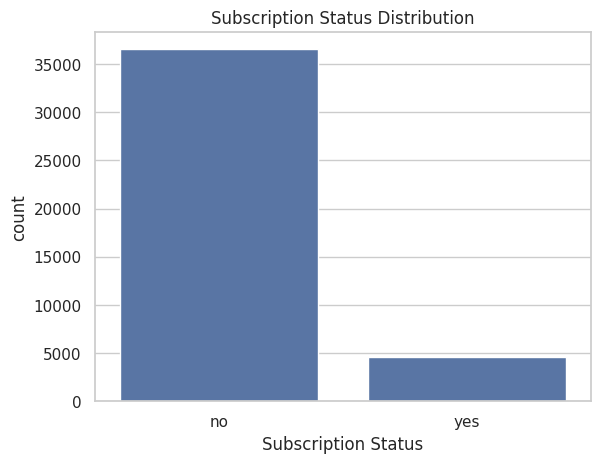

,proportion
Subscription Status,
no,0.887346
yes,0.112654


In [125]:
sns.countplot(x='Subscription Status', data=df)
plt.title("Subscription Status Distribution")
plt.show()

df['Subscription Status'].value_counts(normalize=True)

Distribution of Categorical features

# **Univariate Analysis**

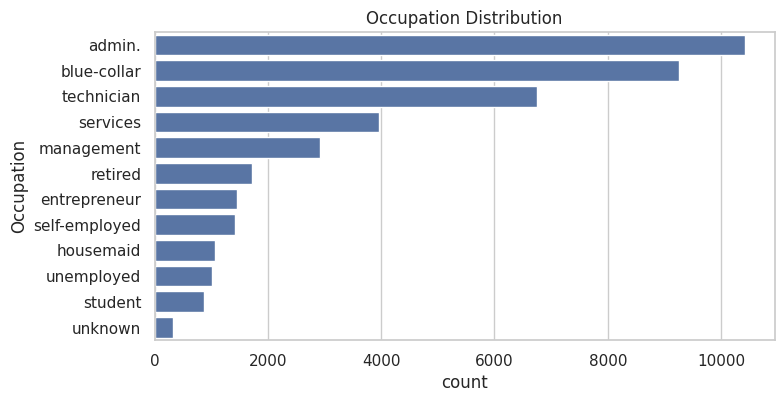

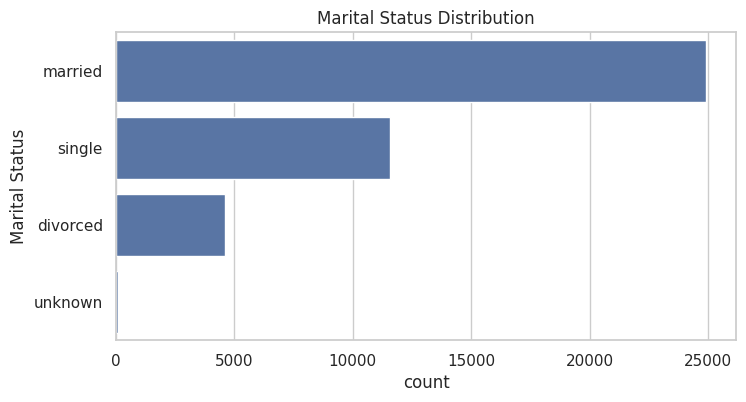

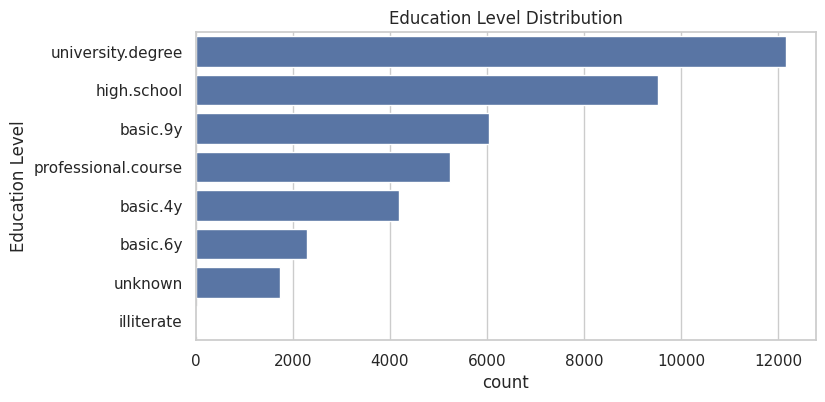

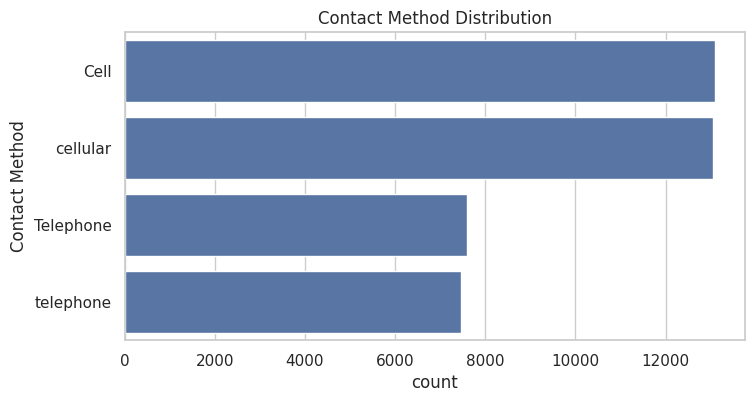

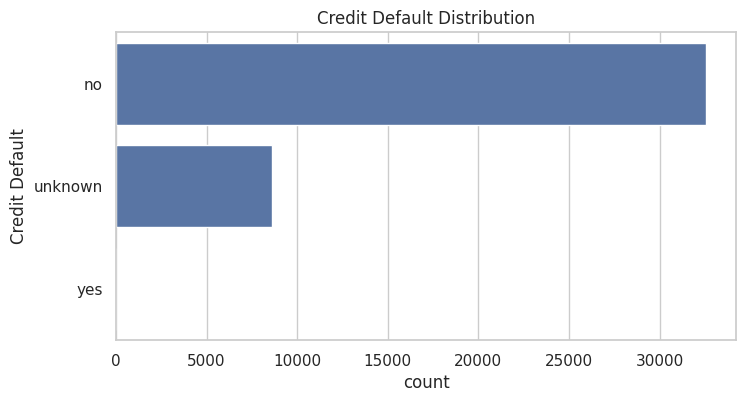

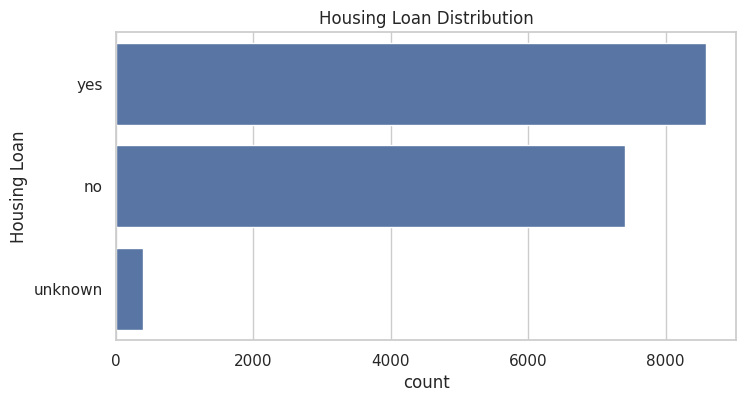

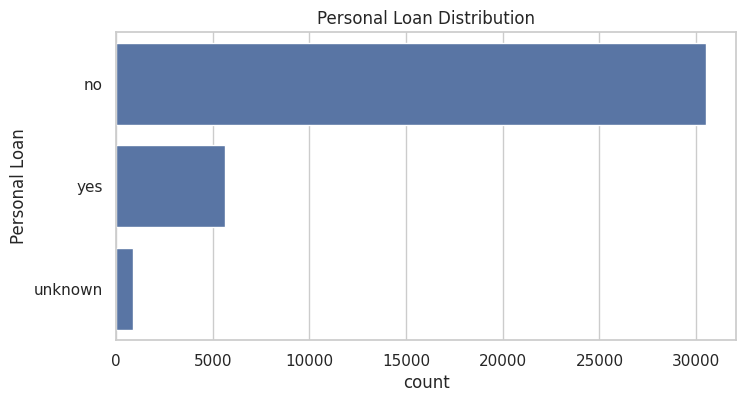

In [126]:
categorical_cols = ['Occupation', 'Marital Status', 'Education Level',
                    'Contact Method', 'Credit Default',
                    'Housing Loan', 'Personal Loan']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.show()


In [156]:
categorical_cols = ['Occupation', 'Marital Status', 'Education Level',
                    'Contact Method', 'Credit Default',
                    'Housing Loan', 'Personal Loan']

print("Count of 'unknown' values in categorical columns:")
for col in categorical_cols:
    unknown_count = df[df[col] == 'unknown'].shape[0]
    print(f"  {col}: {unknown_count}")

Count of 'unknown' values in categorical columns:
  Occupation: 0
  Marital Status: 0
  Education Level: 0
  Contact Method: 0
  Credit Default: 0
  Housing Loan: 0
  Personal Loan: 0


In [157]:
illiterate_count = df[df['Education Level'] == 'illiterate'].shape[0]
print(f"Number of 'illiterate' entries in 'Education Level': {illiterate_count}")

Number of 'illiterate' entries in 'Education Level': 19


In [128]:
def replace_unknown_with_distribution(df, column_name, unknown_label='unknown'):
    """
    Replace 'unknown' in a categorical column by sampling from the
    existing distribution of known values.
    """

    # Known values (exclude 'unknown')
    known = df[df[column_name] != unknown_label][column_name]

    # If nothing to sample from, skip
    if known.empty:
        print(f"Column '{column_name}' has no known values — skipped.")
        return df

    # Count how many unknowns
    n_unknown = (df[column_name] == unknown_label).sum()

    if n_unknown == 0:
        print(f"No 'unknown' values found in '{column_name}'.")
        return df

    # Probability distribution of known categories
    probabilities = known.value_counts(normalize=True)

    # Sample replacements
    replacements = np.random.choice(
        probabilities.index,
        size=n_unknown,
        p=probabilities.values
    )

    # Replace the unknowns
    df.loc[df[column_name] == unknown_label, column_name] = replacements

    print(f"Replaced {n_unknown} 'unknown' values in '{column_name}'.")

    return df

In [129]:
categorical_columns = [
    'Occupation',
    'Marital Status',
    'Education Level',
    'Credit Default',
    'Housing Loan',
    'Personal Loan'
]

for col in categorical_columns:
    df = replace_unknown_with_distribution(df, col)


Replaced 330 'unknown' values in 'Occupation'.
Replaced 80 'unknown' values in 'Marital Status'.
Replaced 1731 'unknown' values in 'Education Level'.
Replaced 8597 'unknown' values in 'Credit Default'.
Replaced 393 'unknown' values in 'Housing Loan'.
Replaced 877 'unknown' values in 'Personal Loan'.


after replacing the unknown

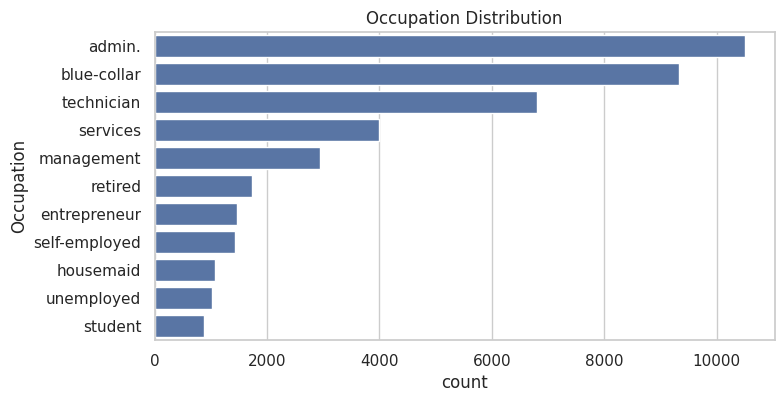

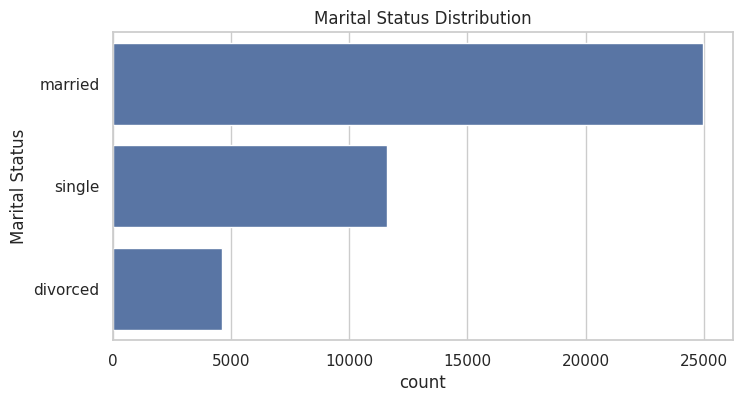

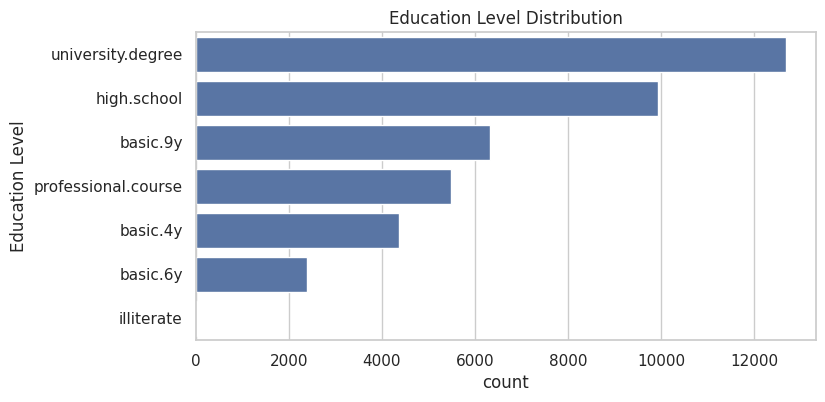

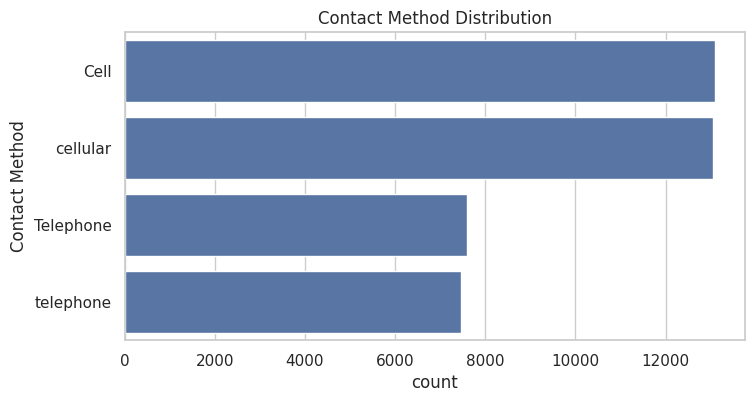

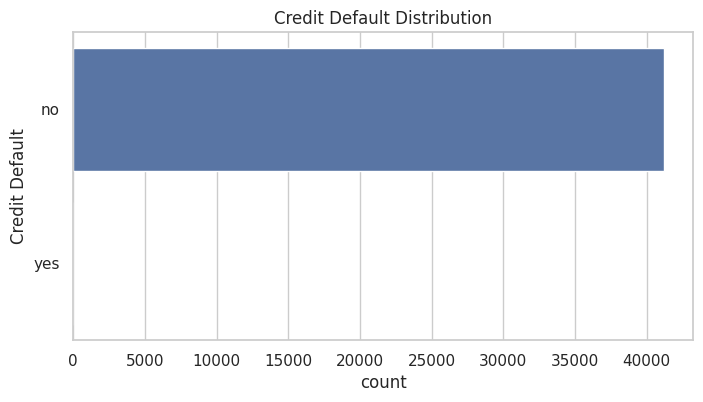

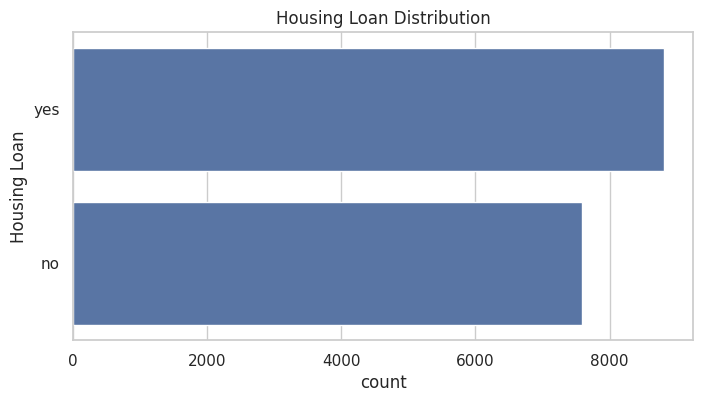

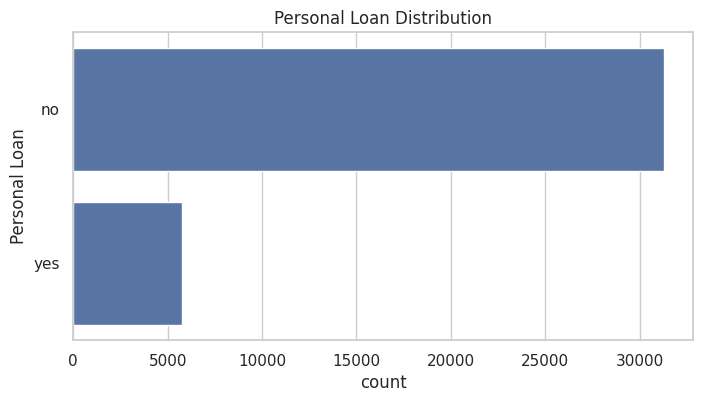

In [130]:
categorical_cols = ['Occupation', 'Marital Status', 'Education Level',
                    'Contact Method', 'Credit Default',
                    'Housing Loan', 'Personal Loan']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.show()

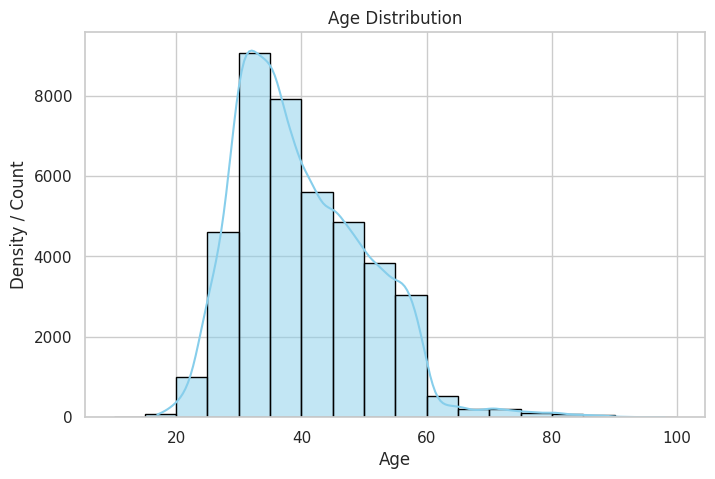

In [131]:
sns.set(style="whitegrid")

# The 'Age' column has already been converted to numeric in a previous step,
# so this line is redundant and causes an AttributeError. It has been removed.

min_age = int(df['Age'].min() // 10 * 10)
max_age = int(df['Age'].max() // 10 * 10 + 10)
bins = range(min_age, max_age + 1, 5)

plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=bins, kde=True, edgecolor='black', color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Density / Count")
plt.show()

# **Birivative Analysis ( need to make graph look nicer)**

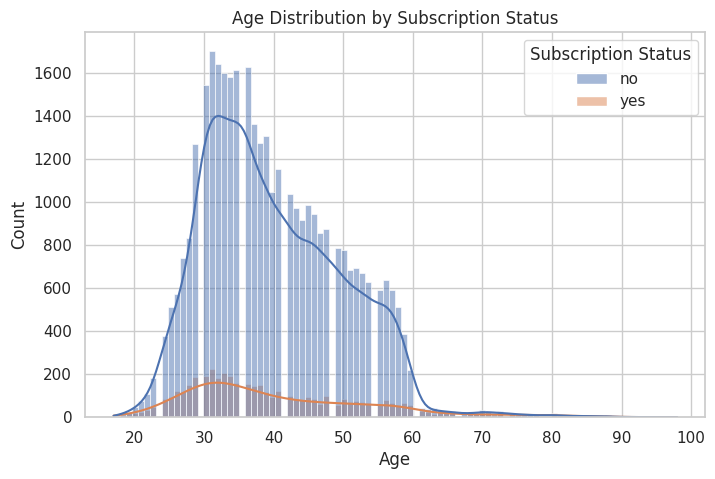

In [132]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Subscription Status', kde=True, alpha=0.5)
plt.title("Age Distribution by Subscription Status")
plt.show()



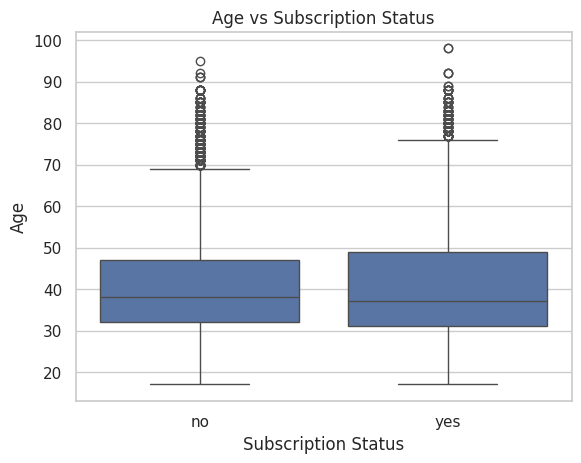

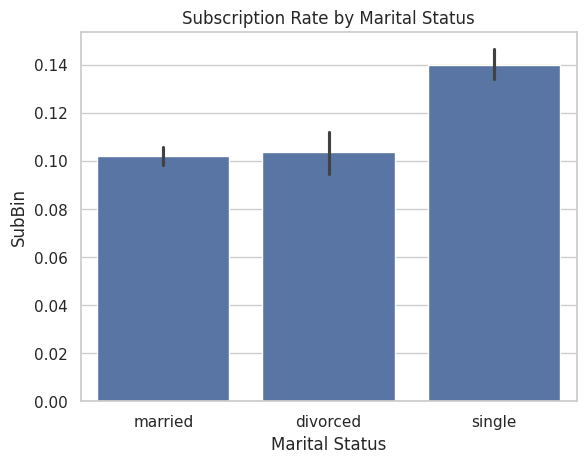

In [133]:
sns.boxplot(x='Subscription Status', y='Age', data=df)
plt.title("Age vs Subscription Status")
plt.show()

df['SubBin'] = df['Subscription Status'].map({'yes': 1, 'no': 0})
sns.barplot(x='Marital Status', y='SubBin', data=df)
plt.title("Subscription Rate by Marital Status")
plt.show()

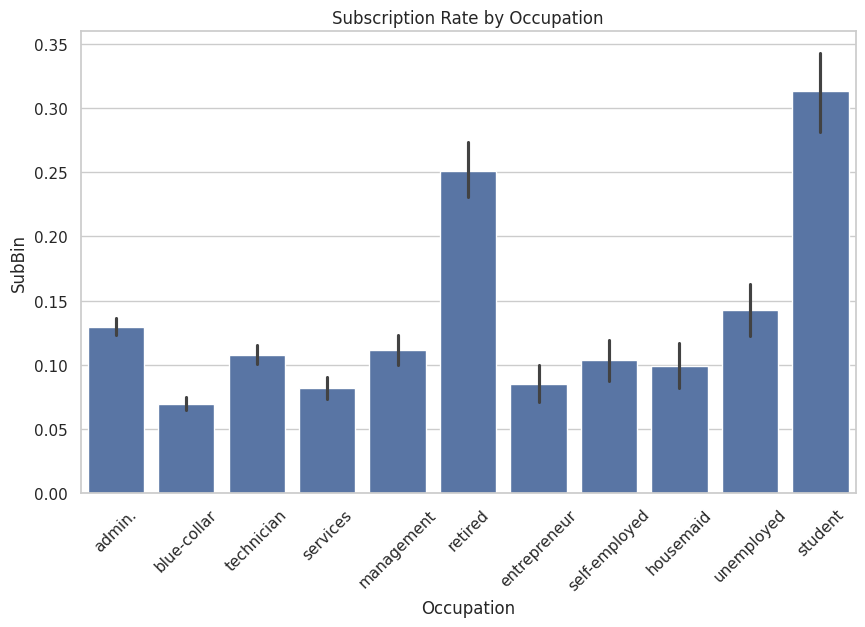

In [134]:
# Convert Subscription Status into binary 1/0
df['SubBin'] = df['Subscription Status'].map({'yes': 1, 'no': 0})
plt.figure(figsize=(10,6))
sns.barplot(x='Occupation', y='SubBin', data=df, order=df['Occupation'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Subscription Rate by Occupation")
plt.show()


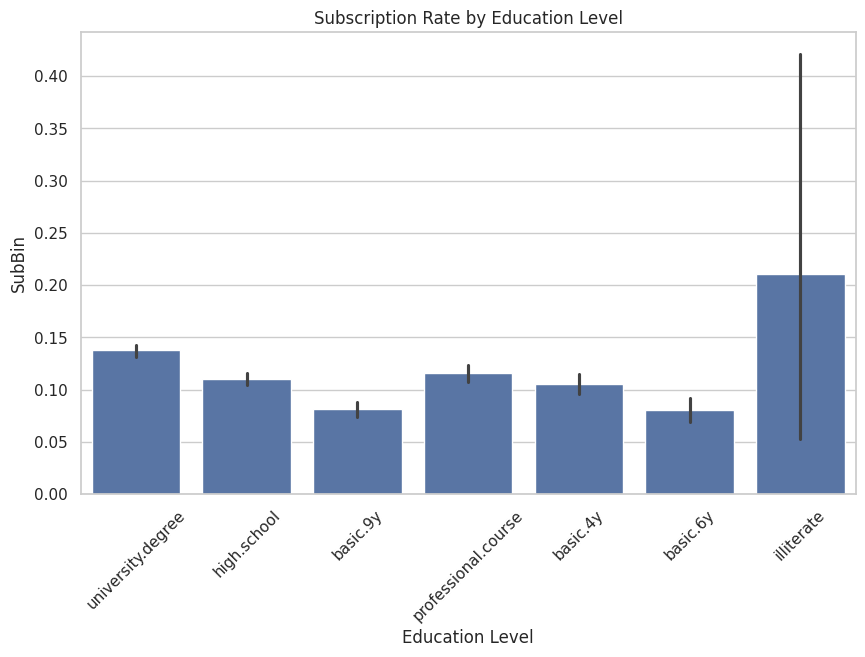

In [135]:
plt.figure(figsize=(10,6))
sns.barplot(x='Education Level', y='SubBin', data=df, order=df['Education Level'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Subscription Rate by Education Level")
plt.show()


In [155]:
# Combine the cell and cellular column together
df['Contact Method'] = df['Contact Method'].replace({
    'cellular': 'Cell'
})
# Combine the Telephone and telephone column together
df['Contact Method'] = df['Contact Method'].replace({
    'telephone': 'Telephone'
})

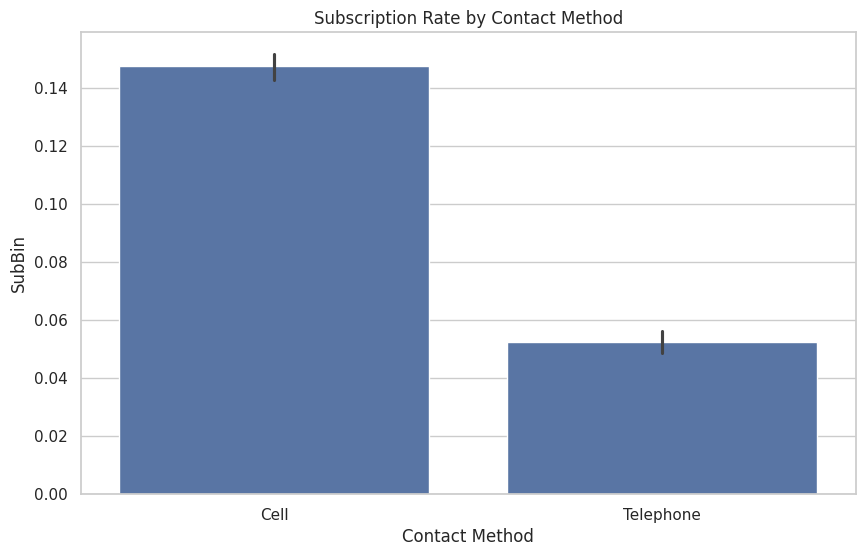

In [154]:
plt.figure(figsize=(10,6))
sns.barplot(x='Contact Method', y='SubBin', data=df, order=df['Contact Method'].value_counts().index)
plt.title("Subscription Rate by Contact Method")
plt.show()




---



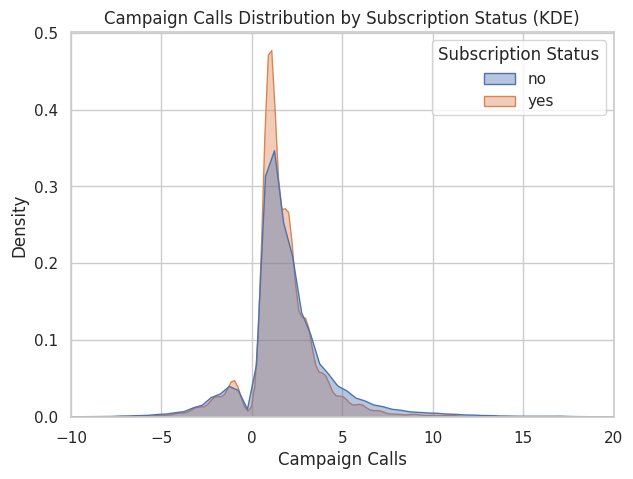

In [138]:
plt.figure(figsize=(7,5))
sns.kdeplot(
    data=df,
    x="Campaign Calls",
    hue="Subscription Status",
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.xlim(-10, 20)
plt.title("Campaign Calls Distribution by Subscription Status (KDE)")
plt.show()




---



In [139]:
# 1. Extract valid distribution (>= 0)
valid_calls = df[df['Campaign Calls'] >= 0]['Campaign Calls']

# 2. Count how many invalid (negative) values
n_invalid = (df['Campaign Calls'] < 0).sum()

print("Number of invalid negative values:", n_invalid)

# 3. Sample from real distribution
replacement_values = np.random.choice(valid_calls, size=n_invalid, replace=True)

# 4. Replace the negative values
df.loc[df['Campaign Calls'] < 0, 'Campaign Calls'] = replacement_values

print("Negative campaign call values replaced.")


Number of invalid negative values: 4153
Negative campaign call values replaced.


after replacing the negative values

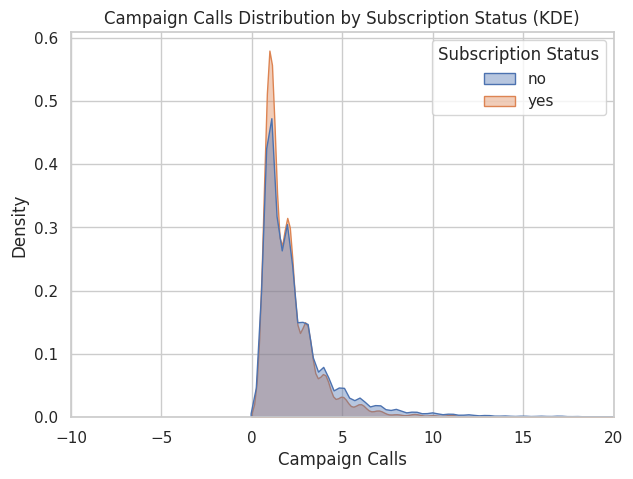

In [140]:
plt.figure(figsize=(7,5))
sns.kdeplot(
    data=df,
    x="Campaign Calls",
    hue="Subscription Status",
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.xlim(-10, 20)
plt.title("Campaign Calls Distribution by Subscription Status (KDE)")
plt.show()

Previous contact days by subscription status

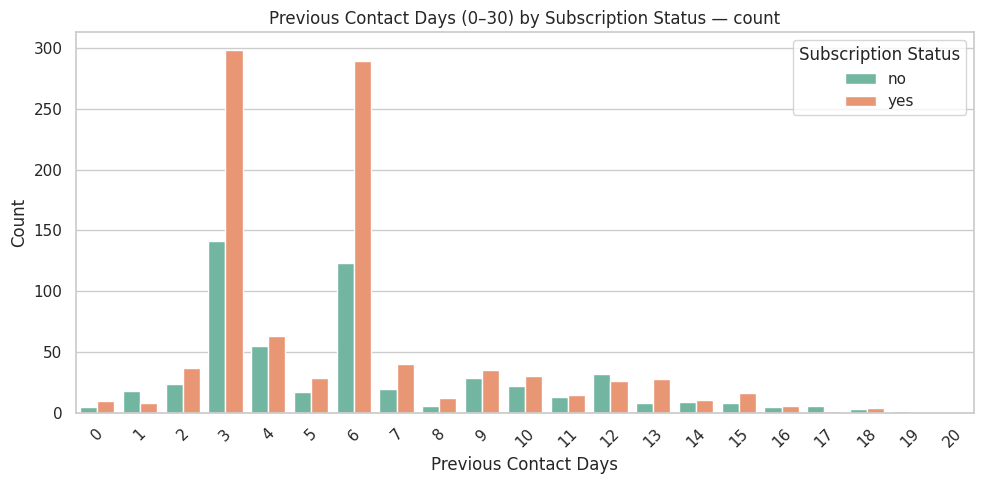

In [141]:
# Filtered out 999 values and limit to 20 days
df_prev = df[(df['Previous Contact Days'] != 999) &
             (df['Previous Contact Days'].between(0, 20))]

plt.figure(figsize=(10,5))

sns.countplot(
    data=df_prev,
    x='Previous Contact Days',
    hue='Subscription Status',
    palette='Set2'
)

plt.title("Previous Contact Days (0–30) by Subscription Status — count")
plt.xlabel("Previous Contact Days")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




---



Age vs Subscription

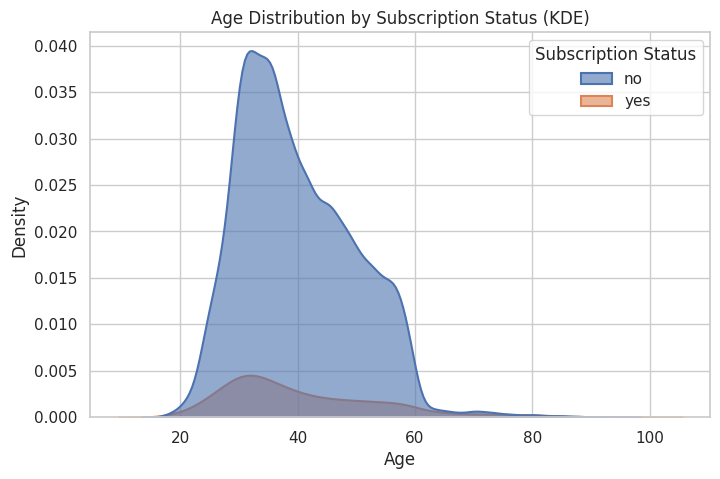

In [142]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='Age', hue='Subscription Status', fill=True, linewidth=1.5, alpha=0.6)
plt.title("Age Distribution by Subscription Status (KDE)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()


Campaign Calls vs Subscription

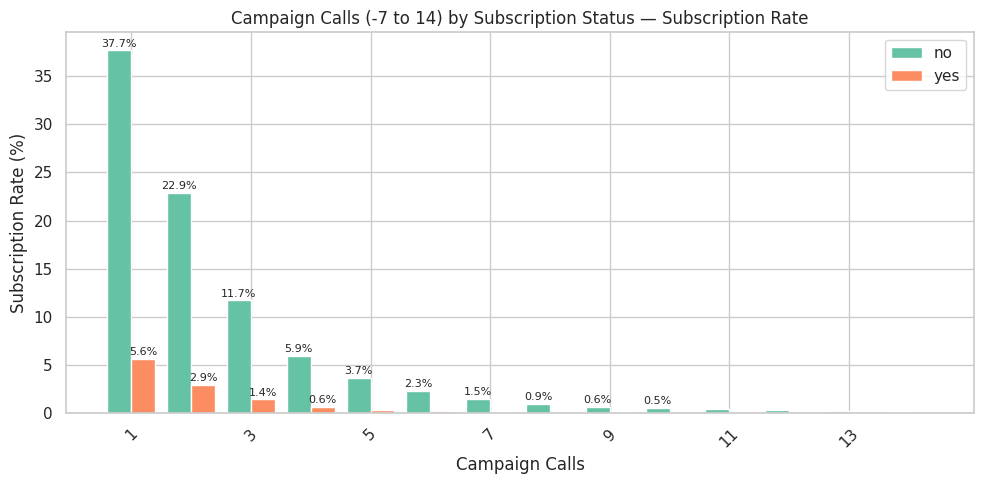

In [143]:
# Filter Campaign Calls between -7 and 14
df_calls = df[df['Campaign Calls'].between(-7, 14)]

plt.figure(figsize=(10,5))

# Compute total percentage per Campaign Calls per Subscription Status
count_table = df_calls.groupby(['Campaign Calls', 'Subscription Status']).size().unstack(fill_value=0)

# Percentage of total
pct_table = (count_table / count_table.values.sum()) * 100

# Plot bars
x = np.arange(len(pct_table.index))
width = 0.4

plt.bar(x - width/2, pct_table['no'], width, label='no', color='#66c2a5')
plt.bar(x + width/2, pct_table['yes'], width, label='yes', color='#fc8d62')

# Add percentage labels on top, only for values > 0.5% to avoid clutter
for i, val in enumerate(pct_table['no']):
    if val > 0.5:
        plt.text(i - width/2, val + 0.2, f"{val:.1f}%", ha='center', va='bottom', fontsize=8)
for i, val in enumerate(pct_table['yes']):
    if val > 0.5:
        plt.text(i + width/2, val + 0.2, f"{val:.1f}%", ha='center', va='bottom', fontsize=8)

# Show only every other tick on x-axis to reduce clutter
plt.xticks(x[::2], pct_table.index[::2], rotation=45)
plt.title("Campaign Calls (-7 to 14) by Subscription Status — Subscription Rate")
plt.xlabel("Campaign Calls")
plt.ylabel("Subscription Rate (%)")
plt.legend()
plt.tight_layout()
plt.show()


# **Multivariate** **Analysis**

Subscription Rate by Contact Method

It has cell and cellular, need to combine

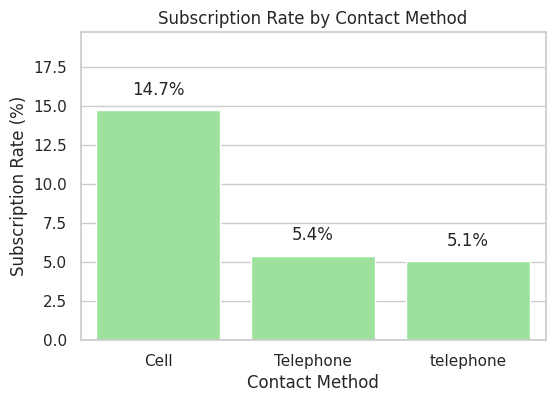

In [144]:
# Compute subscription rate by contact method
contact_rate = df.groupby('Contact Method')['SubBin'].mean().reset_index()

# Convert to percentage
contact_rate['SubPercent'] = contact_rate['SubBin'] * 100

# Plot bar chart
plt.figure(figsize=(6,4))
sns.barplot(data=contact_rate, x='Contact Method', y='SubPercent', color='lightgreen')
plt.title("Subscription Rate by Contact Method")
plt.xlabel("Contact Method")
plt.ylabel("Subscription Rate (%)")
plt.ylim(0, contact_rate['SubPercent'].max() + 5)

# Add percentage labels on bars
for index, row in contact_rate.iterrows():
    plt.text(index, row.SubPercent + 1, f"{row.SubPercent:.1f}%", ha='center')

plt.show()


Pairplot

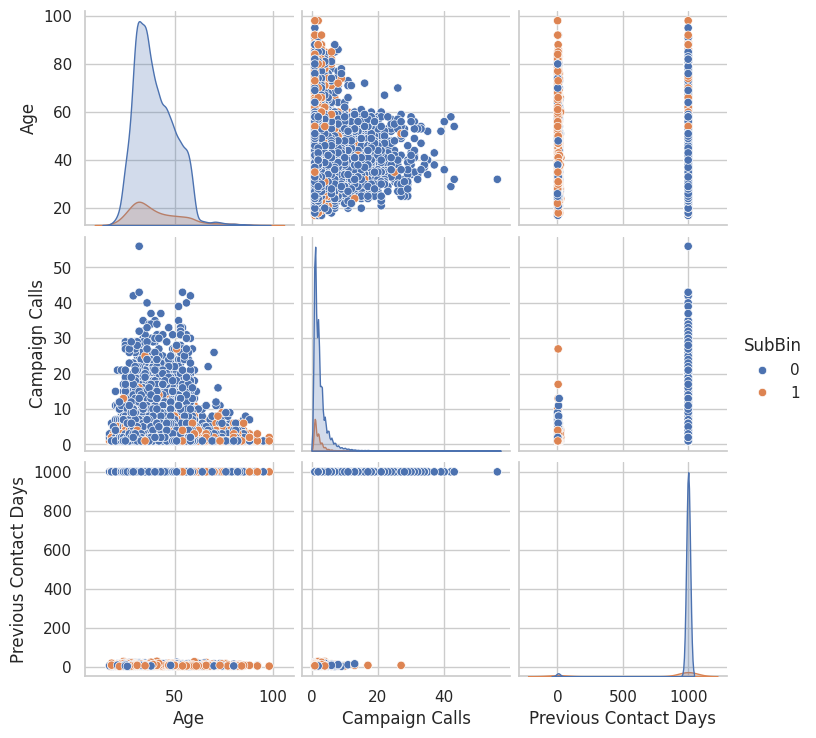

In [145]:
pair_df = df[['Age', 'Campaign Calls', 'Previous Contact Days', 'SubBin']]
sns.pairplot(pair_df, hue='SubBin')
plt.show()


Corelation Heatmap

In [146]:
df_corr = df.copy()
df_corr['Subscription Status'] = df_corr['Subscription Status'].map({'yes':1,'no':0})

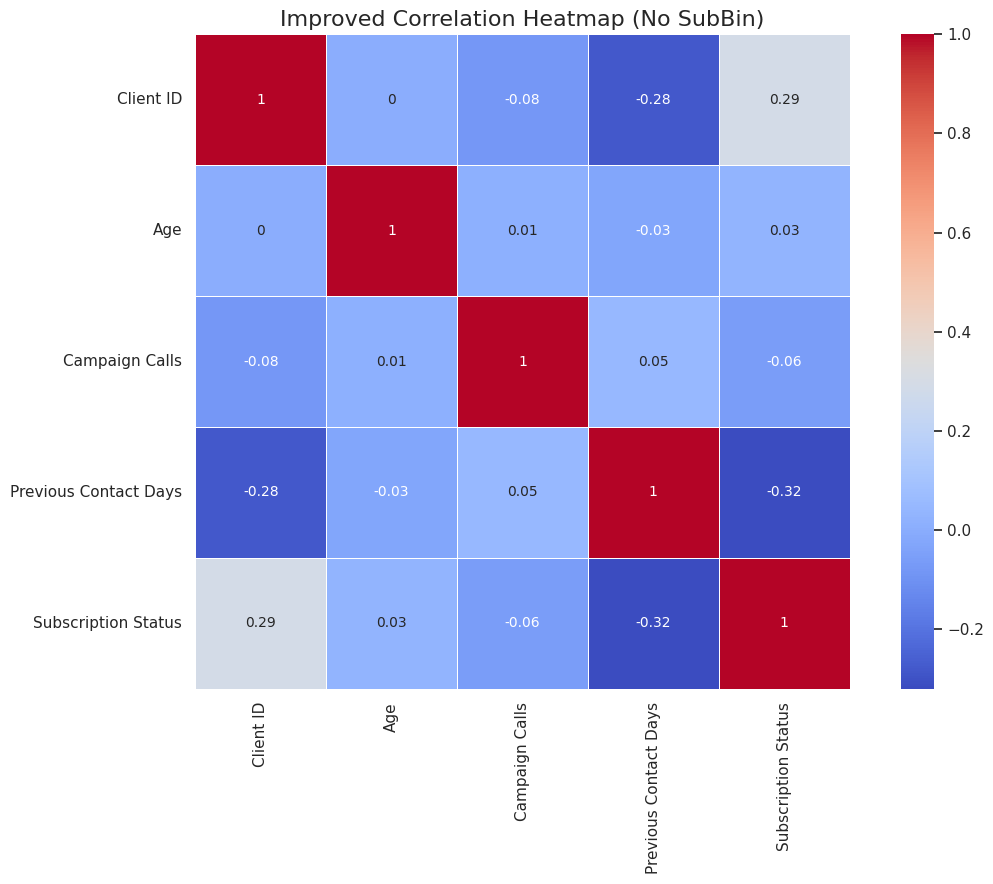

In [147]:
plt.figure(figsize=(12, 9))

# Keep only numeric columns *except SubBin*
numeric_df = df_corr.select_dtypes(include=['int64', 'float64']).drop(columns=['SubBin'], errors='ignore')

# Compute correlation matrix and round
corr = numeric_df.corr().round(2)

# Plot heatmap
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',        # clearer color gradient
    linewidths=0.5,
    square=True,
    annot_kws={"size": 10}  # readable labels
)

plt.title("Improved Correlation Heatmap (No SubBin)", fontsize=16)
plt.tight_layout()
plt.show()


# Task
The task is to correct erroneous 'Age' entries of 150 in the `df` DataFrame by replacing them with randomly sampled ages drawn from the distribution of all other valid ages present in the dataset. This will involve converting the 'Age' column to a numeric type, identifying the positions of the '150' age outliers, creating a sampling distribution from the non-outlier ages, replacing the identified outliers with values sampled from this distribution, and finally verifying the correction and displaying the updated age distribution.

## Convert Age to Numeric

### Subtask:
Ensure the 'Age' column in `df` is of a numeric type.


**Reasoning**:
Verify that the 'Age' column in the `df` DataFrame is of a numeric data type as instructed.



In [148]:
print(df['Age'].dtype)


int64


## Identify Outlier Positions

### Subtask:
Identify the indices of all entries in the 'Age' column that currently have a value of 150, as these are the values to be replaced.


**Reasoning**:
To identify the outlier positions, I will filter the DataFrame `df` where the 'Age' column is equal to 150 and extract their indices.



In [149]:
outlier_indices = df.index[df['Age'] == 150].tolist()

print(f"Indices of Age = 150 outliers: {outlier_indices}")
print(f"Number of Age = 150 outliers: {len(outlier_indices)}")

Indices of Age = 150 outliers: []
Number of Age = 150 outliers: 0


## Summary:

### Data Analysis Key Findings
*   The 'Age' column in the DataFrame is already of a numeric type, specifically `int64`, requiring no conversion.
*   Upon inspection, no 'Age' entries with a value of 150 were found in the dataset. The count of such outliers was 0.

### Insights or Next Steps
*   The premise of the task, which involved correcting erroneous 'Age' entries of 150, does not apply to the current dataset as no such values exist.
*   Further steps regarding sampling and replacement are unnecessary given the absence of the specified outliers. If erroneous 'Age' values are still suspected, their definition or the data source should be re-examined.
